In [1]:
using LCIO
using LCIO: getFloatVal
using StatsPlots
using LaTeXStrings

In [2]:
const fnames = Dict(
    "μμH_eLpR" => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106479.Pe2e2h.eL.pR-00001-ILDminiDST.slcio",
    "μμH_eRpL" => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106480.Pe2e2h.eR.pL-00001-ILDminiDST.slcio",
    "zz_sl_eLpR" => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106575.P4f_zz_sl.eL.pR-00001-ILDminiDST.slcio", 
    "zz_sl_eRpL" => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I106576.P4f_zz_sl.eR.pL-00001-ILDminiDST.slcio"
)

Dict{String,String} with 4 entries:
  "zz_sl_eRpL" => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I1065…
  "μμH_eLpR"   => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I1064…
  "μμH_eRpL"   => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I1064…
  "zz_sl_eLpR" => "rv01-16-p10_250.sv01-14-01-p00.mILD_o1_v05.E250-TDR_ws.I1065…

In [3]:
function inv_mass(part1, part2)
    e = getEnergy(part1) + getEnergy(part2)
    p = getMomentum(part1) + getMomentum(part2)
    sqrt(e^2 - sum(p.^2))
end

inv_mass (generic function with 1 method)

In [27]:
const isDelphes = false

function recoil_mass(μ₁, μ₂)
    E_initial = 250.0
    px_initial = 0.0
    # in full sim & SGV, correct for crossing angle
    if !isDelphes
         px_initial = E_initial * 0.007
         E_initial = 2.0sqrt((0.5*E_initial)^2 + px_initial^2)
    end
    recoilE = E_initial - getEnergy(μ₁) - getEnergy(μ₂)
    recoilP = [px_initial, 0, 0] - getMomentum(μ₁) - getMomentum(μ₂)
    M² = recoilE^2 - sum(recoilP.^2)
    if M² < 0 return 0 end
    sqrt(M²)
end

recoil_mass (generic function with 1 method)

In [28]:
const lumi_target = 900.0
const epol_target = -0.8
const ppol_target = +0.3

0.3

In [32]:
signal_recoilMassList = Float64[]
signal_weights = Float64[]
background_recoilMassList = Float64[]
background_weights = Float64[]

for entry in fnames
    FNAME = entry.second
    nEvents = 0
    fail2muon = 0
    LCIO.open(FNAME) do reader
        nevt_per_file = length(reader)
        for event in reader
            global nEvents
            global fail2muon

            # CrossSection_fb is the event parameter storing the generator cross-section for this event
            xsection = LCIO.getFloatVal(LCIO.getParameters(event), "CrossSection_fb")
            nEvents += 1
    #         beamPol1 & beamPol2 are the event parameters storing the generated beam polarisations of this event
    #         = 1 = 100% = right-handed  / -1 = -100% = left-handed
    #         polarisation weights for {LR, RL, LL, RR} events, as example for target P(e-,e+)=(-80%,+30%):
    #         LR: polweight = (1-epol_target)*(1+ppol_target)/4.; // -80%,+30% => 1.8 * 1.3 / 4. = 0.585
    #         RL: polweight = (1+epol_target)*(1-ppol_target)/4.; // -80%,+30% => 0.2 * 0.7 / 4. = 0.035
    #         LL: polweight = (1-epol_target)*(1-ppol_target)/4.; // -80%,+30% => 1.8 * 0.7 / 4. = 0.315
    #         RR: polweight = (1+epol_target)*(1+ppol_target)/4.; // -80%,+30% => 0.2 * 1.3 / 4. = 0.065
            epol = getFloatVal(getParameters(event), "beamPol1")
            ppol = getFloatVal(getParameters(event), "beamPol2")
            polweight = (1.0 + epol*epol_target)*(1.0 + ppol*ppol_target)/4.0

    #       assume one file per process-polarisation combination 
    #       - in case of several files per process-polarisation combination, need to add up *beforehand* 
    #       the numbers of events of all the files belonging to the same process-polarisation combination! 
            weight = polweight * xsection * lumi_target / nevt_per_file
            if nEvents == 1
                println(entry.first, " events, weight = ", weight)
            end
            muons = getCollection(event, "IsolatedMuons")
            pfos = getCollection(event, "PandoraPFOs")
            # for simplicity only consider events with two muons
            if length(muons) != 2
                fail2muon += 1
                continue
            end
            # the two muons and their four-vectors
            μ₁ = muons[1]
            μ₂ = muons[2]
            if entry.first in ("μμH_eLpR", "μμH_eRpL")
                push!(signal_recoilMassList, recoil_mass(μ₁, μ₂))
                push!(signal_weights, weight)
            else
                push!(background_recoilMassList, recoil_mass(μ₁, μ₂))
                push!(background_weights, weight)
            end
        end
    end
end

zz_sl_eRpL events, weight = 0.6095042478522297
μμH_eLpR events, weight = 0.5265065500646255
μμH_eRpL events, weight = 0.031501219331876266
zz_sl_eLpR events, weight = 20.638320291975504


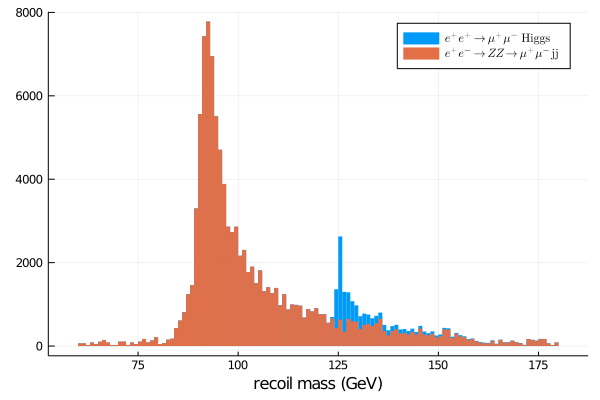

In [71]:
combined_recoil = vcat([signal_recoilMassList, background_recoilMassList]...)
combined_weights = vcat([signal_weights, background_weights]...)
plot(combined_recoil,
    weights=combined_weights,
    seriestype=:histogram,
    linewidth=0,
    barwidth=1.0,
    bins=range(60, 180, length=121),
    label=L"e^{+}e^{+} \rightarrow \mu^{+}\mu^{-}\; \mathrm{Higgs}"
)
plot!(background_recoilMassList, weights=background_weights,
    seriestype=:histogram,
    linewidth=0,
    barwidth=1.0,
    bins=range(60, 180, length=121),
    label=L"e^{+}e^{-} \rightarrow Z Z \rightarrow \mu^{+}\mu^{-} \mathrm{jj}",
    xlabel="recoil mass (GeV)"
)